In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
# @title Figure Settings
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [37]:
# @title Plotting functions

def plot_isis(single_neuron_isis):
  plt.hist(single_neuron_isis, bins=50, histtype="stepfilled")
  plt.axvline(single_neuron_isis.mean(), color="orange", label="Mean ISI")
  plt.xlabel("ISI duration (s)")
  plt.ylabel("Number of spikes")
  plt.legend()

In [38]:
#@title Data retrieval
#@markdown This cell downloads the example dataset that we will use in this tutorial.
import io
import requests
import pandas as pd
r = requests.get('https://osf.io/sy5xt/download')
if r.status_code != 200:
  print('Failed to download data')
else:
  spike_times = np.load(io.BytesIO(r.content), allow_pickle=True)['spike_times']

#spike_times = pd.read_csv('DataSetCoursework_DHA.txt')
#print(spike_times)

In [39]:
idx = 0
print(
  type(spike_times[idx]),
  spike_times[idx].shape,
  sep="\n",
)

<class 'numpy.ndarray'>
(826,)


In [40]:
i_neurons = [0, 321]
i_print = slice(0, 5)

for i in i_neurons:
  print(
    "Neuron {}:".format(i),
    spike_times[i].dtype,
    spike_times[i][i_print],
    "\n",
    sep="\n"
  )

Neuron 0:
float32
[ 0.8149   14.822467 24.9646   25.1436   38.8709  ]


Neuron 321:
float32
[1.0698667 1.1536334 1.2403667 1.7072    1.799    ]




Note that this time we’ve checked the NumPy dtype rather than the Python variable type. These two arrays contain floating point numbers (“floats”) with 32 bits of precision.

The basic picture is coming together:

spike_times is 1D, its entries are NumPy arrays, and its length is the number of neurons (734): by indexing it, we select a subset of neurons.

An array in spike_times is also 1D and corresponds to a single neuron; its entries are floating point numbers, and its length is the number of spikes attributed to that neuron. By indexing it, we select a subset of spike times for that neuron.

Visually, you can think of the data structure as looking something like this:

In [41]:
n_neurons = len(spike_times)
total_spikes_per_neuron = [len(spike_times_i) for spike_times_i in spike_times]

print(f"Number of neurons: {n_neurons}")
print(f"Number of spikes for first five neurons: {total_spikes_per_neuron[:5]}")

Number of neurons: 734
Number of spikes for first five neurons: [826, 2818, 3953, 646, 1115]


As we’ve seen, the number of spikes over the entire recording is variable between neurons. More generally, some neurons tend to spike more than others in a given period. Let’s explore what the distribution of spiking looks like across all the neurons in the dataset.

Are most neurons “loud” or “quiet”, compared to the average? To see, we’ll define bins of constant width in terms of total spikes and count the neurons that fall in each bin. This is known as a “histogram”.

You can plot a histogram with the matplotlib function plt.hist. If you just need to compute it, you can use the numpy function np.histogram instead.

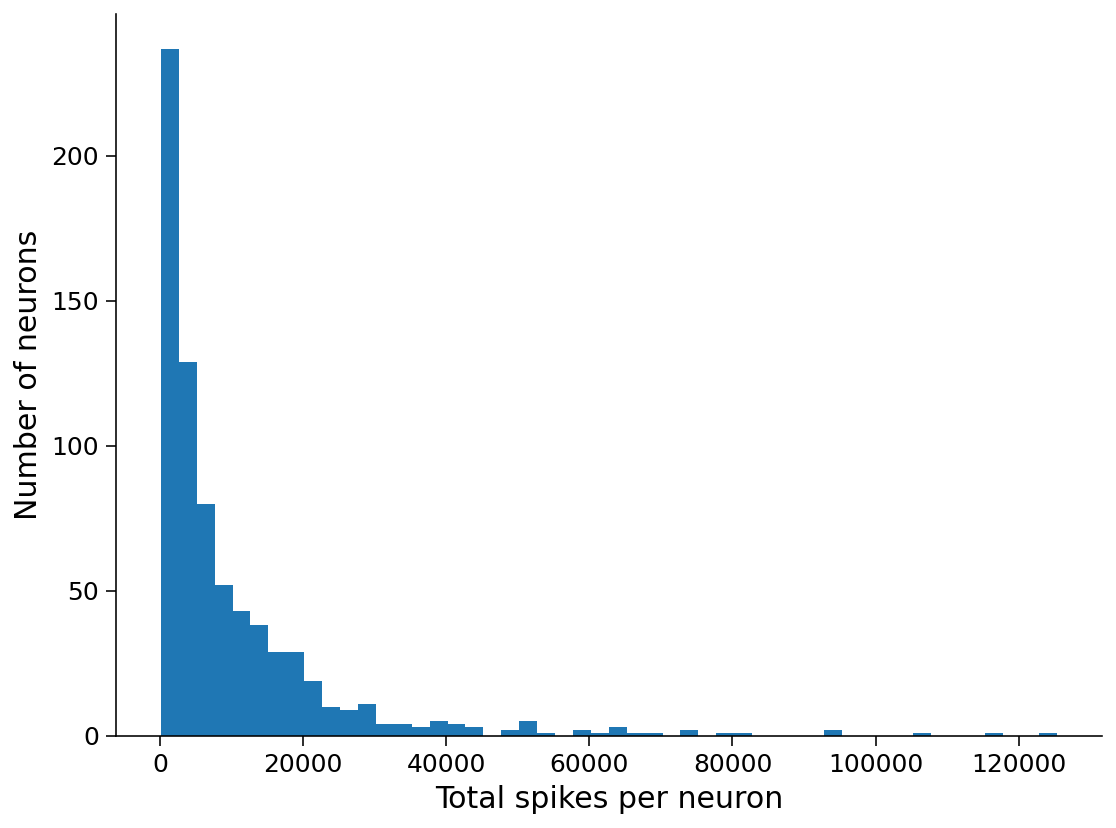

In [42]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons");

In [43]:
mean_spike_count = np.mean(total_spikes_per_neuron)
print(mean_spike_count)
frac_below_mean = (total_spikes_per_neuron < mean_spike_count).mean()
print(f"{frac_below_mean:2.1%} of neurons are below the mean")

10319.351498637603
68.0% of neurons are below the mean


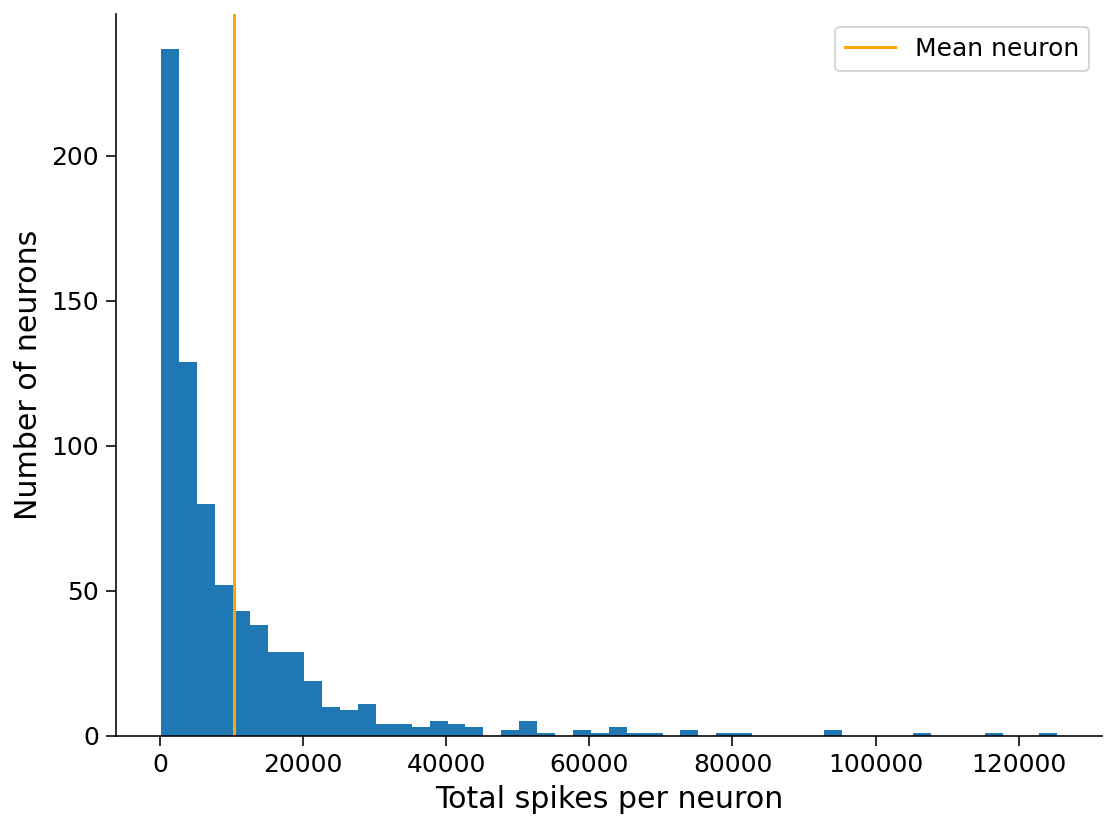

In [44]:
plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
plt.xlabel("Total spikes per neuron")
plt.ylabel("Number of neurons")
plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
plt.legend();

This shows that the majority of neurons are relatively “quiet” compared to the mean, while a small number of neurons are exceptionally “loud”: they must have spiked more often to reach a large count.



# comparing mean and median neurons

5128.0
10319.351498637603


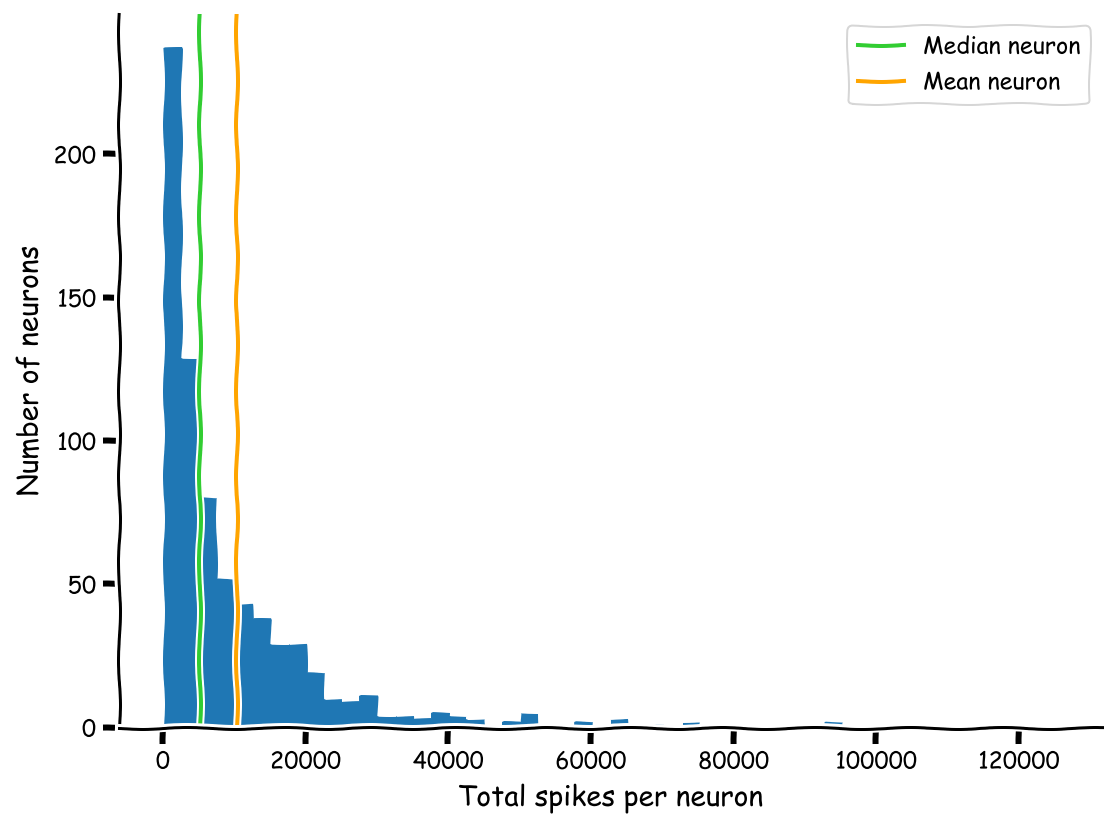

In [45]:
# Compute median spike count
median_spike_count = np.median(total_spikes_per_neuron)  # Hint: Try the function np.median

# Visualize median, mean, and histogram
with plt.xkcd():
  plt.hist(total_spikes_per_neuron, bins=50, histtype="stepfilled")
  plt.axvline(median_spike_count, color="limegreen", label="Median neuron")
  plt.axvline(mean_spike_count, color="orange", label="Mean neuron")
  plt.xlabel("Total spikes per neuron")
  plt.ylabel("Number of neurons")
  plt.legend()
print(median_spike_count)
print(mean_spike_count)

# Visualizing neuronal spiking activity
Now we’ll visualize trains of spikes. Because the recordings are long, we will first define a short time interval and restrict the visualization to only the spikes in this interval. We defined a helper function, restrict_spike_times, to do this for you. If you call help() on the function, it will tell you a little bit about itself:



In [46]:
# @markdown Execute this cell for helper function `restrict_spike_times`
def restrict_spike_times(spike_times, interval):
  """Given a spike_time dataset, restrict to spikes within given interval.

  Args:
    spike_times (sequence of np.ndarray): List or array of arrays,
      each inner array has spike times for a single neuron.
    interval (tuple): Min, max time values; keep min <= t < max.

  Returns:
    np.ndarray: like `spike_times`, but only within `interval`
  """
  interval_spike_times = []
  for spikes in spike_times:
    interval_mask = (spikes >= interval[0]) & (spikes < interval[1])
    interval_spike_times.append(spikes[interval_mask])
  return np.array(interval_spike_times, object)

In [47]:
help(restrict_spike_times)

Help on function restrict_spike_times in module __main__:

restrict_spike_times(spike_times, interval)
    Given a spike_time dataset, restrict to spikes within given interval.
    
    Args:
      spike_times (sequence of np.ndarray): List or array of arrays,
        each inner array has spike times for a single neuron.
      interval (tuple): Min, max time values; keep min <= t < max.
    
    Returns:
      np.ndarray: like `spike_times`, but only within `interval`



In [48]:
t_interval = (5, 15)  # units are seconds after start of recording
interval_spike_times = restrict_spike_times(spike_times, t_interval)

In [49]:
original_counts = sum([len(spikes) for spikes in spike_times])
interval_counts = sum([len(spikes) for spikes in interval_spike_times])
frac_interval_spikes = interval_counts / original_counts
print(f"{frac_interval_spikes:.2%} of the total spikes are in the interval")

0.33% of the total spikes are in the interval


\Now we’ll visualize trains of spikes. Because the recordings are long, we will first define a short time interval and restrict the visualization to only the spikes in this interval. We defined a helper function, restrict_spike_times, to do this for you. If you call help() on the function, it will tell you a little bit about itself:

In [50]:
spike_times_flat = np.concatenate(spike_times)
experiment_duration = np.ptp(spike_times_flat)
interval_duration = t_interval[1] - t_interval[0]

frac_interval_time = interval_duration / experiment_duration
print(f"{frac_interval_time:.2%} of the total time is in the interval")

0.37% of the total time is in the interval


These two values—the fraction of total spikes and the fraction of total time—are similar. This suggests the average spike rate of the neuronal population is not very different in this interval compared to the entire recording.

# Plotting spike trains and rasters



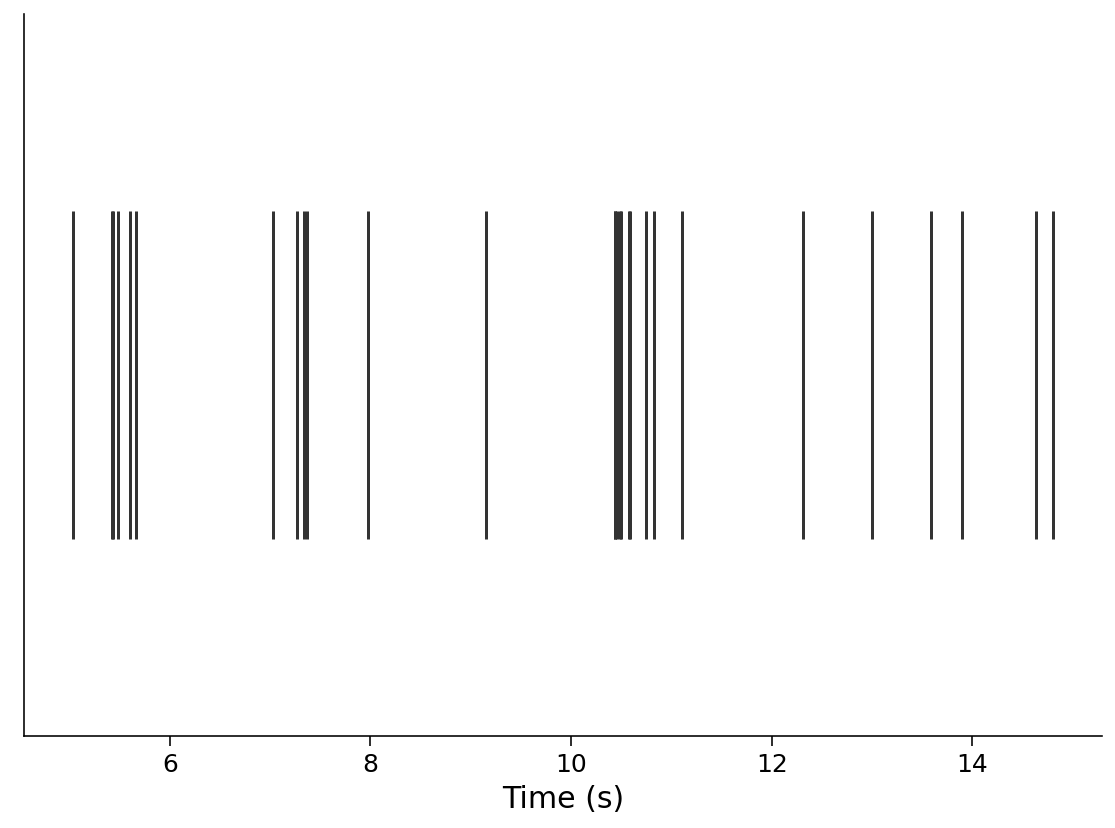

In [51]:
neuron_idx = 1
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

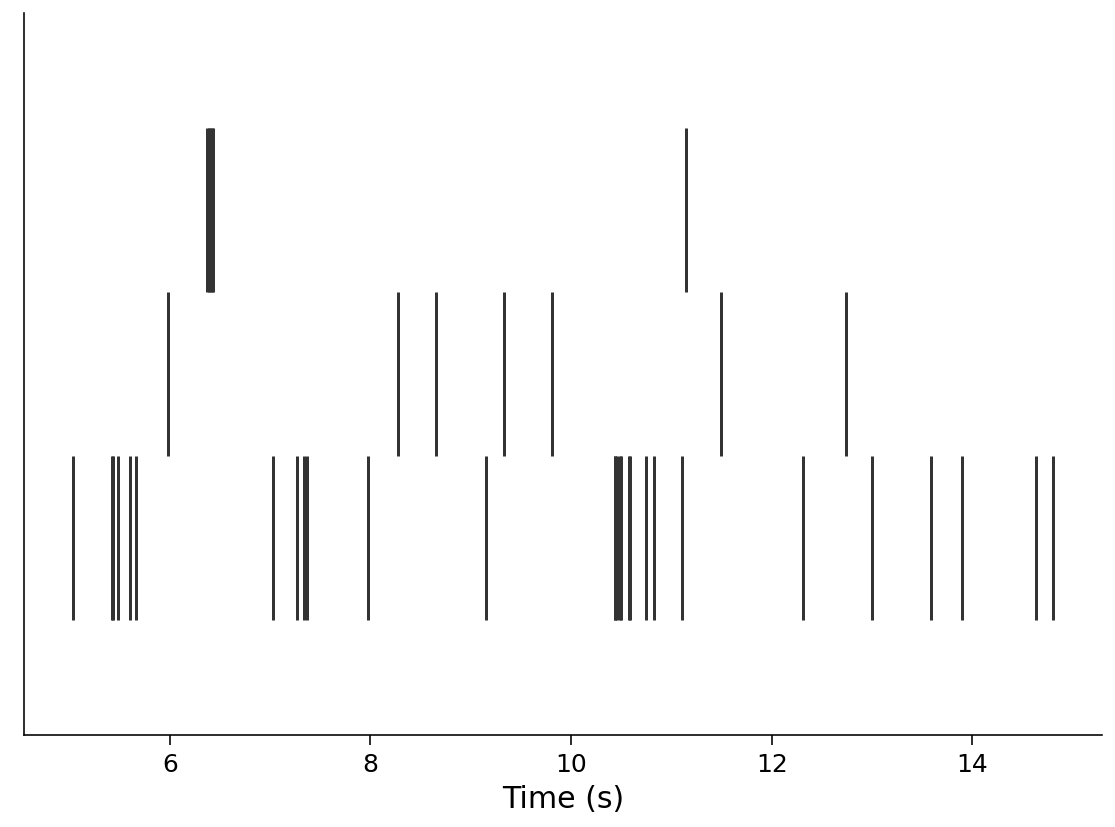

In [52]:
neuron_idx = [1, 11, 51]
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

This makes a “raster” plot, where the spikes from each neuron appear in a different row.

Plotting a large number of neurons can give you a sense for the characteristics in the population. Let’s show every 5th neuron that was recorded:

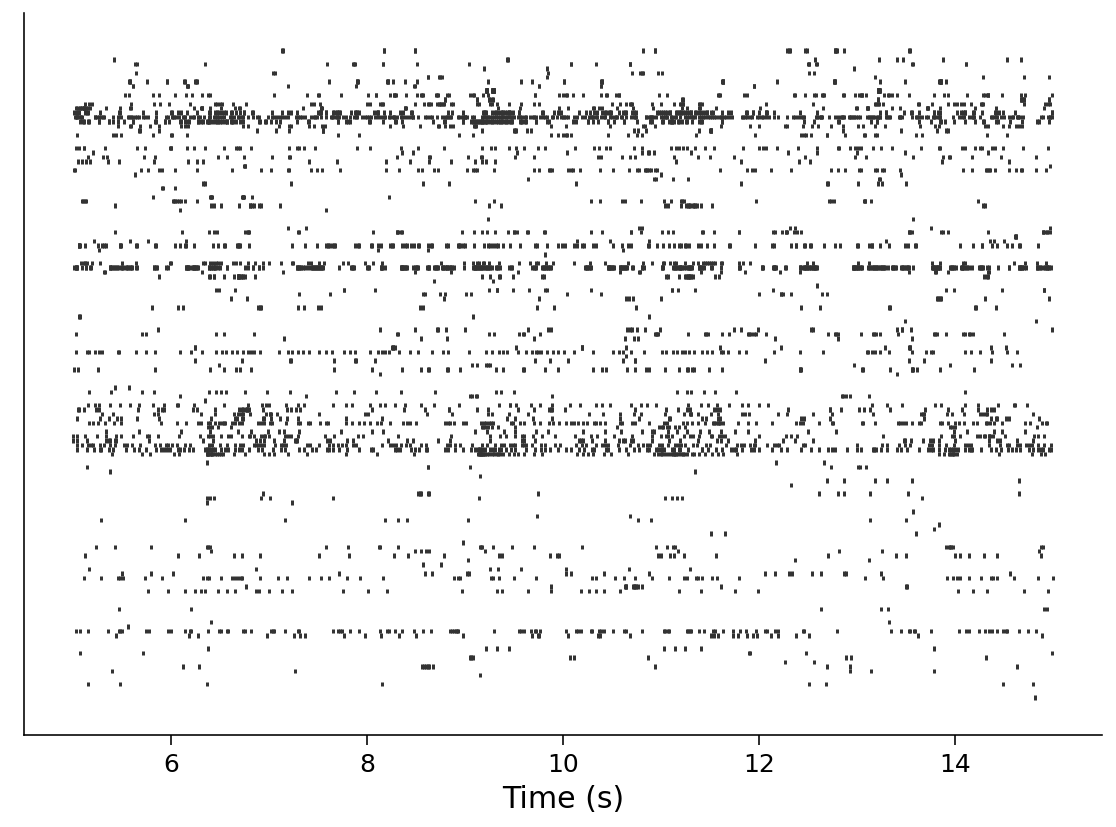

In [53]:
neuron_idx = np.arange(0, len(spike_times), 5)
plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

In [54]:
def compute_single_neuron_isis(spike_times, neuron_idx):
  """Compute a vector of ISIs for a single neuron given spike times.
  Args:
    spike_times (list of 1D arrays): Spike time dataset, with the first
      dimension corresponding to different neurons.
    neuron_idx (int): Index of the unit to compute ISIs for.
  Returns:
    isis (1D array): Duration of time between each spike from one neuron.
  """
  # Extract the spike times for the specified neuron
    single_neuron_spikes = spike_times[neuron_idx]

  # Compute the ISIs for this set of spikes
  # Hint: the function np.diff computes discrete differences along an array
    isis = np.diff(single_neuron_spikes)

    return isis

# Compute ISIs
single_neuron_isis = compute_single_neuron_isis(spike_times, neuron_idx=283)

# Visualize ISIs
with plt.xkcd():
    plot_isis(single_neuron_isis)

IndentationError: unexpected indent (4223210117.py, line 11)

# ENTROPY FINDING

it is used find the exact firing rate of neurons

Neurons can only fire so often in a fixed period of time, as the act of emitting a spike consumes energy that is depleted and must eventually be replenished. To communicate effectively for downstream computation, the neuron would need to make good use of its limited spiking capability. This becomes an optimization problem:

What is the optimal way for a neuron to fire in order to maximize its ability to communicate information?

In order to explore this question, we first need to have a quantifiable measure for information. Shannon introduced the concept of entropy to do just that, and defined it as

(131)
Hb(X)=−∑x∈Xp(x)logbp(x)
where H is entropy measured in units of base b and p(x) is the probability of observing the event x from the set of all possible events in X. See the Bonus Section 1 for a more detailed look at how this equation was derived.

The most common base of measuring entropy is b=2, so we often talk about bits of information, though other bases are used as well (e.g. when b=e we call the units nats).

First, let’s explore how entropy changes between some simple discrete probability distributions. In the rest of this tutorial we will refer to these as probability mass functions (PMF), where p(xi) equals the ith value in an array, and mass refers to how much of the distribution is contained at that value.

For our first PMF, we will choose one where all of the probability mass is located in the middle of the distribution.

In [ ]:
#@title Figure Settings
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

#@title Plotting Functions

def plot_pmf(pmf,isi_range):
  """Plot the probability mass function."""
  ymax = max(0.2, 1.05 * np.max(pmf))
  pmf_ = np.insert(pmf, 0, pmf[0])
  plt.plot(bins, pmf_, drawstyle="steps")
  plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
  plt.title(f"Neuron {neuron_idx}")
  plt.xlabel("Inter-spike interval (s)")
  plt.ylabel("Probability mass")
  plt.xlim(isi_range);
  plt.ylim([0, ymax])

In [ ]:
n_bins = 50  # number of points supporting the distribution
x_range = (0, 1)  # will be subdivided evenly into bins corresponding to points

bins = np.linspace(*x_range, n_bins + 1)  # bin edges

pmf = np.zeros(n_bins)
pmf[len(pmf) // 2] = 1.0  # middle point has all the mass

# Since we already have a PMF, rather than un-binned samples, `plt.hist` is not
# suitable. Instead, we directly plot the PMF as a step function to visualize
# the histogram:
pmf_ = np.insert(pmf, 0, pmf[0])  # this is necessary to align plot steps with bin edges
plt.plot(bins, pmf_, drawstyle="steps")
# `fill_between` provides area shading
plt.fill_between(bins, pmf_, step="pre", alpha=0.4)
plt.xlabel("x")
plt.ylabel("p(x)")
plt.xlim(x_range)
plt.ylim(0, 1);

In [ ]:
def entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits.
  This is a measure of information in the distribution. For a totally
  deterministic distribution, where samples are always found in the same bin,
  then samples from the distribution give no more information and the entropy
  is 0.
  For now this assumes `pmf` arrives as a well-formed distribution (that is,
  `np.sum(pmf)==1` and `not np.any(pmf < 0)`)
  Args:
    pmf (np.ndarray): The probability mass function for a discrete distribution
      represented as an array of probabilities.
  Returns:
    h (number): The entropy of the distribution in `pmf`.
  """
  # reduce to non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf > 0]

  # implement the equation for Shannon entropy (in bits)
  h = -np.sum(pmf * np.log2(pmf))

  # return the absolute value (avoids getting a -0 result)
  return np.abs(h)

# Call entropy function and print result
print(f"{entropy(pmf):.2f} bits")

Information, neurons, and spikes

Entropy of different distributions

What does the information content (or distributional entropy) of these measures say about our theory of nervous systems?

We’ll consider three hypothetical neurons that all have the same mean ISI, but with different distributions:

Deterministic

Uniform

Exponential

Fixing the mean of the ISI distribution is equivalent to fixing its inverse: the neuron’s mean firing rate. If a neuron has a fixed energy budget and each of its spikes has the same energy cost, then by fixing the mean firing rate, we are normalizing for energy expenditure. This provides a basis for comparing the entropy of different ISI distributions. In other words: if our neuron has a fixed budget, what ISI distribution should it express (all else being equal) to maximize the information content of its outputs?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats 

n_bins = 50
mean_isi = 0.025
isi_range = (0, 0.25)

bins = np.linspace(*isi_range, n_bins + 1)
mean_idx = np.searchsorted(bins, mean_isi)

# 1. all mass concentrated on the ISI mean
pmf_single = np.zeros(n_bins)
pmf_single[mean_idx] = 1.0

# 2. mass uniformly distributed about the ISI mean
pmf_uniform = np.zeros(n_bins)
pmf_uniform[0:2*mean_idx] = 1 / (2 * mean_idx)

# 3. mass exponentially distributed about the ISI mean
pmf_exp = stats.expon.pdf(bins[1:], scale=mean_isi)
pmf_exp /= np.sum(pmf_exp)
print(
  f"Deterministic: {entropy(pmf_single):.2f} bits",
  f"Uniform: {entropy(pmf_uniform):.2f} bits",
  f"Exponential: {entropy(pmf_exp):.2f} bits",
  sep="\n",
)
#@title
#@markdown Run this cell to plot the three PMFs
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

dists =  [# (subplot title, pmf, ylim)
          ("(1) Deterministic", pmf_single, (0, 1.05)),
          ("(1) Uniform", pmf_uniform, (0, 1.05)),
          ("(1) Exponential", pmf_exp, (0, 1.05))]

for ax, (label, pmf_, ylim) in zip(axes, dists):
  pmf_ = np.insert(pmf_, 0, pmf_[0])
  ax.plot(bins, pmf_, drawstyle="steps")
  ax.fill_between(bins, pmf_, step="pre", alpha=0.4)
  ax.set_title(label)
  ax.set_xlabel("Inter-spike interval (s)")
  ax.set_ylabel("Probability mass")
  ax.set_xlim(isi_range);
  ax.set_ylim(ylim);

Computing probabilities from histogram

In the previous example we created the PMFs by hand to illustrate idealized scenarios. How would we compute them from data recorded from actual neurons?

One way is to convert the ISI histograms we’ve previously computed into discrete probability distributions using the following equation:

pi=ni/∑ini

where pi is the probability of an ISI falling within a particular interval i and ni is the count of how many ISIs were observed in that interval.

Your second exercise is to implement a method that will produce a probability mass function from an array of ISI bin counts.

To verify your solution, we will compute the probability distribution of ISIs from real neural data taken from the Steinmetz dataset.

In [ ]:
def pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  pmf = counts / np.sum(counts)

  return pmf


# Get neuron index
neuron_idx = 1

# Get counts of ISIs from Steinmetz data
isi = np.diff(spike_times[neuron_idx])
bins = np.linspace(*isi_range, n_bins + 1)
counts, _ = np.histogram(isi, bins)

# Compute pmf
pmf = pmf_from_counts(counts)

# Visualize
plot_pmf(pmf,isi_range)

In [ ]:
#@title
#@markdown **Run the cell** to enable the sliders.

#pmf-probability mass function

def _pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  pmf = counts / np.sum(counts)
  return pmf

def _entropy(pmf):
  """Given a discrete distribution, return the Shannon entropy in bits."""
  # remove non-zero entries to avoid an error from log2(0)
  pmf = pmf[pmf > 0]
  h = -np.sum(pmf * np.log2(pmf))
  # absolute value applied to avoid getting a -0 result
  return np.abs(h)

@widgets.interact(neuron=widgets.IntSlider(0, min=0, max=(len(spike_times)-1)))
def steinmetz_pmf(neuron):
  """ Given a neuron from the Steinmetz data, compute its PMF and entropy """
  isi = np.diff(spike_times[neuron])
  bins = np.linspace(*isi_range, n_bins + 1)
  counts, _ = np.histogram(isi, bins)
  pmf = _pmf_from_counts(counts)

  plot_pmf(pmf,isi_range)
  plt.title(f"Neuron {neuron}: H = {_entropy(pmf):.2f} bits")

Notation
(134)
H(X)bxp(x)ISInipientropy of random variable Xbase, e.g. b=2 or b=eevent xprobability of observing event xinterspike intervalcount of observed ISIs in interval iprobability of of an ISI falling within a particular interval i

take the part ii from the pdf:
    https://compneuro.neuromatch.io/tutorials/W1D1_ModelTypes/student/W1D1_Outro.html

# MODEL FITTING

Linear regression: makes predictions about the linear relationship between the input variable x(contrast) and the output variable y (neural response)

y = 01 * x + 0zero ; y is neural response , 01 is linear weight, x is contrast, 0zero  is  intercept

In [ ]:
def plot_observed_vs_predicted(x, y, y_hat, theta_hat):
  """ Plot observed vs predicted data

  Args:
    x (ndarray): observed x values
    y (ndarray): observed y values
    y_hat (ndarray): predicted y values
    theta_hat (ndarray):
  """
  fig, ax = plt.subplots()
  ax.scatter(x, y, label='Observed')  # our data scatter plot
  ax.plot(x, y_hat, color='r', label='Fit')  # our estimated model
  # plot residuals
  ymin = np.minimum(y, y_hat)
  ymax = np.maximum(y, y_hat)
  ax.vlines(x, ymin, ymax, 'g', alpha=0.5, label='Residuals')
  ax.set(
      title=fr"$\hat{{\theta}}$ = {theta_hat:0.2f}, MSE = {np.mean((y - y_hat)**2):.2f}",
      xlabel='x',
      ylabel='y'
  )
  ax.legend()

# compute MSE

In this exercise you will implement a method to compute the mean squared error for a set of inputs x, measurements y, and slope estimate θ^. Here, x and y are vectors of data points. We will then compute and print the mean squared error for 3 different choices of theta.

As a reminder, the equation for computing the estimated y for a single data point is:

(139)
y^i=θxi
and for mean squared error is:

(140)
minθ1N∑i=1N(yi−y^i)2

In [ ]:
np.random.seed(121)

# Let's set some parameters
theta = 1.2
n_samples = 30

# Draw x and then calculate y
x = 10 * np.random.rand(n_samples)  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)  # sample from a standard normal distribution
y = theta * x + noise

# Plot the results
fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

def mse(x, y, theta_hat):
  """Compute the mean squared error
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    theta_hat (float): An estimate of the slope parameter
  Returns:
    float: The mean squared error of the data with the estimated parameter.
  """

  # Compute the estimated y
     y_hat = theta_hat * x

  # Compute mean squared error
    mse = np.mean((y - y_hat)**2)

    return mse

theta_hats = [0.75, 1.0, 1.5]
for theta_hat in theta_hats:
  print(f"theta_hat of {theta_hat} has an MSE of {mse(x, y, theta_hat):.2f}")

We see that θ^=1.0 is our best estimate from the three we tried. Looking just at the raw numbers, however, isn’t always satisfying, so let’s visualize what our estimated model looks like over the data.

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))
for theta_hat, ax in zip(theta_hats, axes):

  # True data
  ax.scatter(x, y, label='Observed')  # our data scatter plot

  # Compute and plot predictions
  y_hat = theta_hat * x
  ax.plot(x, y_hat, color='r', label='Fit')  # our estimated model

  ax.set(
      title= fr'$\hat{{\theta}}$= {theta_hat}, MSE = {np.mean((y - y_hat)**2):.2f}',
      xlabel='x',
      ylabel='y'
  );

axes[0].legend()

#MSE Explorer
Using an interactive widget, we can easily see how changing our slope estimate changes our model fit. We display the residuals, the differences between observed and predicted data, as line segments between the data point (observed response) and the corresponding predicted response on the model fit line.

In [ ]:
@widgets.interact(theta_hat=widgets.FloatSlider(1.0, min=0.0, max=2.0))
def plot_data_estimate(theta_hat):
  y_hat = theta_hat * x
  plot_observed_vs_predicted(x, y, y_hat, theta_hat)

# Least-squares optimization
While the approach detailed above (computing MSE at various values of θ^) quickly got us to a good estimate, it still relied on evaluating the MSE value across a grid of hand-specified values. If we didn’t pick a good range to begin with, or with enough granularity, we might miss the best possible estimator. Let’s go one step further, and instead of finding the minimum MSE from a set of candidate estimates, let’s solve for it analytically.

We can do this by minimizing the cost function. Mean squared error is a convex objective function, therefore we can compute its minimum using calculus. Please see video or Bonus Section 1 for this derivation! After computing the minimum, we find that:

While the approach detailed above (computing MSE at various values of θ^) quickly got us to a good estimate, it still relied on evaluating the MSE value across a grid of hand-specified values. If we didn’t pick a good range to begin with, or with enough granularity, we might miss the best possible estimator. Let’s go one step further, and instead of finding the minimum MSE from a set of candidate estimates, let’s solve for it analytically.

We can do this by minimizing the cost function. Mean squared error is a convex objective function, therefore we can compute its minimum using calculus. Please see video or Bonus Section 1 for this derivation! After computing the minimum, we find that:

In [ ]:
def solve_normal_eqn(x, y):
  """Solve the normal equations to produce the value of theta_hat that minimizes
    MSE.
    Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
  Returns:
    float: the value for theta_hat arrived from minimizing MSE
  """

  # Compute theta_hat analytically
  theta_hat = (x.T @ y) / (x.T @ x)

  return theta_hat


theta_hat = solve_normal_eqn(x, y)
y_hat = theta_hat * x

with plt.xkcd():
  plot_observed_vs_predicted(x, y, y_hat, theta_hat)

# fINDING MAXIMUM LIKELIHOOD ESTIMATION(MLE)

In [ ]:
# @title Plotting Functions
def plot_density_image(x, y, theta, sigma=1, ax=None):
  """ Plots probability distribution of y given x, theta, and sigma

  Args:

    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    theta (float): Slope parameter
    sigma (float): standard deviation of Gaussian noise

  """

  # plot the probability density of p(y|x,theta)
  if ax is None:
    fig, ax = plt.subplots()

  xmin, xmax = np.floor(np.min(x)), np.ceil(np.max(x))
  ymin, ymax = np.floor(np.min(y)), np.ceil(np.max(y))
  xx = np.linspace(xmin, xmax, 50)
  yy = np.linspace(ymin, ymax, 50)

  surface = np.zeros((len(yy), len(xx)))
  for i, x_i in enumerate(xx):
    surface[:, i] = stats.norm(theta * x_i, sigma).pdf(yy)

  ax.set(xlabel='x', ylabel='y')

  return ax.imshow(surface, origin='lower', aspect='auto', vmin=0, vmax=None,
            cmap=plt.get_cmap('Wistia'),
            extent=[xmin, xmax, ymin, ymax])

# Gaussian noise 
Probabilistic Models

Now that we have a model of our noise component ϵ as random variable, how do we incorporate this back into our original linear model from before? Consider again our simplified model y=θx+ϵ where the noise has zero mean and unit variance ϵ∼N(0,1). We can now also treat y as a random variable drawn from a Gaussian distribution where μ=θx and σ2=1:

(149)
y∼N(θx,1)
which is to say that the probability of observing y given x and parameter θ is

(150)
p(y|x,θ)=12π−−√e−12(y−θx)2
Note that in this and the following sections, we will focus on a single data point (a single pairing of x and y). We have dropped the subscript i just for simplicity (that is, we use x for a single data point, instead of xi).

Now, let’s revisit our original sample dataset where the true underlying model has θ=1.2.

Execute this cell to generate some simulated data


This time we can plot the density of p(y|x,θ=1.2) and see how p(y) changes for different values of x.

In [ ]:
# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence

np.random.seed(121)
theta = 1.2
n_samples = 30
x = 10 * np.random.rand(n_samples) # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples) # sample from a standard normal distribution
y = theta * x + noise

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

# Invokes helper function to generate density image plots from data and parameters
im = plot_density_image(x, y, 1.2, ax=ax1)
plt.colorbar(im, ax=ax1)
ax1.axvline(8, color='k')
ax1.set(title=r'p(y | x, $\theta$=1.2)')

# Plot pdf for given x
ylim = ax1.get_ylim()
yy = np.linspace(ylim[0], ylim[1], 50)
ax2.plot(yy, stats.norm(theta * 8, 1).pdf(yy), color='orange', linewidth=2)
ax2.set(
    title=r'p(y|x=8, $\theta$=1.2)',
    xlabel='y',
    ylabel='probability density');

# Likelihood Estimation

Now that we have our probabilistic model, we turn back to our original challenge of finding a good estimate for θ that fits our data. Given the inherent uncertainty when dealing in probabilities, we talk about the likelihood that some estimate θ^ fits our data. The likelihood function L(θ) is equal to the probability density function parameterized by that θ

In [ ]:
def likelihood(theta_hat, x, y):
  """The likelihood function for a linear model with noise sampled from a
    Gaussian distribution with zero mean and unit variance.
  Args:
    theta_hat (float): An estimate of the slope parameter.
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
  Returns:
    float: the likelihood value for the theta_hat estimate
  """
  sigma = 1
  # Compute Gaussian likelihood
  pdf = 1 / np.sqrt(2 * np.pi * sigma**2) * np.exp(-(y - theta_hat * x)**2 / (2 * sigma**2))
  return pdf
print(likelihood(1.0, x[1], y[1]))

# Confidence intervals and bootstrapping

BOOTSTRAPPIING

Bootstrapping is a widely applicable method to assess confidence/uncertainty about estimated parameters, it was originally proposed by Bradley Efron. The idea is to generate many new synthetic datasets from the initial true dataset by randomly sampling from it, then finding estimators for each one of these new datasets, and finally looking at the distribution of all these estimators to quantify our confidence.

Note that each new resampled datasets will be the same size as our original one, with the new data points sampled with replacement i.e. we can repeat the same data point multiple times. Also note that in practice we need a lot of resampled datasets, here we use 2000.

To explore this idea, we will start again with our noisy samples along the line yi=1.2xi+ϵi, but this time, we only use half the data points as last time (15 instead of 30).

In [ ]:
def plot_original_and_resample(x, y, x_, y_):
  """ Plot the original sample and the resampled points from this sample.

  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    x_ (ndarray): An array of shape (samples,) with a subset of input values from x
    y_ (ndarray): An array of shape (samples,) with a the corresponding subset
      of measurement values as x_ from y

  """
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
  ax1.scatter(x, y)
  ax1.set(title='Original', xlabel='x', ylabel='y')

  ax2.scatter(x_, y_, color='c')

  ax2.set(title='Resampled', xlabel='x', ylabel='y',
          xlim=ax1.get_xlim(), ylim=ax1.get_ylim());

In [ ]:
# setting a fixed seed to our random number generator ensures we will always
# get the same psuedorandom number sequence
np.random.seed(121)

# Let's set some parameters
theta = 1.2
n_samples = 15

# Draw x and then calculate y
x = 10 * np.random.rand(n_samples)  # sample from a uniform distribution over [0,10)
noise = np.random.randn(n_samples)  # sample from a standard normal distribution
y = theta * x + noise

fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

# Resample Dataset with Replacement

In this exercise you will implement a method to resample a dataset with replacement. The method accepts x and y arrays. It should return a new set of x′ and y′ arrays that are created by randomly sampling from the originals.

We will then compare the original dataset to a resampled dataset.

In [ ]:
def resample_with_replacement(x, y):
  """Resample data points with replacement from the dataset of `x` inputs and
  `y` measurements.
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
  Returns:
    ndarray, ndarray: The newly resampled `x` and `y` data points.
  """

  # Get array of indices for resampled points
    sample_idx = np.random.choice(len(x), size=len(x), replace=True)

  # Sample from x and y according to sample_idx
    x_ = x[sample_idx]
    y_ = y[sample_idx]

    return x_, y_

x_, y_ = resample_with_replacement(x, y)

with plt.xkcd():
  plot_original_and_resample(x, y, x_, y_)

In the resampled plot on the right, the actual number of points is the same, but some have been repeated so they only display once.

Now that we have a way to resample the data, we can use that in the full bootstrapping process.

In [ ]:
#Bootstrap Estimates

def bootstrap_estimates(x, y, n=2000):
  """Generate a set of theta_hat estimates using the bootstrap method.
  Args:
    x (ndarray): An array of shape (samples,) that contains the input values.
    y (ndarray): An array of shape (samples,) that contains the corresponding
      measurement values to the inputs.
    n (int): The number of estimates to compute
  Returns:
    ndarray: An array of estimated parameters with size (n,)
  """
  theta_hats = np.zeros(n)

  # Loop over number of estimates
  for i in range(n):

    # Resample x and y
    x_, y_ = resample_with_replacement(x, y)

    # Compute theta_hat for this sample
    theta_hats[i] = solve_normal_eqn(x_, y_)

  return theta_hats

# Set random seed
np.random.seed(123)

# Get bootstrap estimates
theta_hats = bootstrap_estimates(x, y, n=2000)
print(theta_hats[0:5])

# Multiple Linear Regression and polynomial regression

In [ ]:
def evaluate_fits(order_list, mse_list):
  """ Compare the quality of multiple polynomial fits
  by plotting their MSE values.

  Args:
    order_list (list): list of the order of polynomials to be compared
    mse_list (list): list of the MSE values for the corresponding polynomial fit
  """
  fig, ax = plt.subplots()
  ax.bar(order_list, mse_list)
  ax.set(title='Comparing Polynomial Fits', xlabel='Polynomial order', ylabel='MSE')

def plot_fitted_polynomials(x, y, theta_hat):
  """ Plot polynomials of different orders

  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    theta_hat (dict): polynomial regression weights for different orders
  """

  x_grid = np.linspace(x.min() - .5, x.max() + .5)

  plt.figure()

  for order in range(0, max_order + 1):
    X_design = make_design_matrix(x_grid, order)
    plt.plot(x_grid, X_design @ theta_hat[order]);

  plt.ylabel('y')
  plt.xlabel('x')
  plt.plot(x, y, 'C0.');
  plt.legend([f'order {o}' for o in range(max_order + 1)], loc=1)
  plt.title('polynomial fits')
  plt.show()

In [ ]:
#orginary least squares Estimator
np.random.seed(1234)

# Set parameters
theta = [0, -2, -3]
n_samples = 40

# Draw x and calculate y
n_regressors = len(theta)
x0 = np.ones((n_samples, 1))
x1 = np.random.uniform(-2, 2, (n_samples, 1))
x2 = np.random.uniform(-2, 2, (n_samples, 1))
X = np.hstack((x0, x1, x2))
noise = np.random.randn(n_samples)
y = X @ theta + noise


ax = plt.subplot(projection='3d')
ax.plot(X[:,1], X[:,2], y, '.')

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='y'
)
plt.tight_layout() 

def ordinary_least_squares(X, y):
  """Ordinary least squares estimator for linear regression.
  Args:
    X (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)
  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """

  # Compute theta_hat using OLS
    theta_hat = np.linalg.inv(X.T @ X) @ X.T @ y

  return theta_hat


theta_hat = ordinary_least_squares(X, y)
print(theta_hat)

In [ ]:
# Compute predicted data
theta_hat = ordinary_least_squares(X, y)
y_hat = X @ theta_hat

# Compute MSE
print(f"MSE = {np.mean((y - y_hat)**2):.2f}")

Finally, the following code will plot a geometric visualization of the data points (blue) and fitted plane.

In [ ]:
theta_hat = ordinary_least_squares(X, y)
xx, yy = np.mgrid[-2:2:50j, -2:2:50j]
y_hat_grid = np.array([xx.flatten(), yy.flatten()]).T @ theta_hat[1:]
y_hat_grid = y_hat_grid.reshape((50, 50))

ax = plt.subplot(projection='3d')
ax.plot(X[:, 1], X[:, 2], y, '.')
ax.plot_surface(xx, yy, y_hat_grid, linewidth=0, alpha=0.5, color='C1',
                cmap=plt.get_cmap('coolwarm'))

for i in range(len(X)):
  ax.plot((X[i, 1], X[i, 1]),
          (X[i, 2], X[i, 2]),
          (y[i], y_hat[i]),
          'g-', alpha=.5)

ax.set(
    xlabel='$x_1$',
    ylabel='$x_2$',
    zlabel='y'
)
plt.tight_layout()

# Polynomial Regression
So far today, you learned how to predict outputs from inputs by fitting a linear regression model. We can now model all sorts of relationships, including in neuroscience!

One potential problem with this approach is the simplicity of the model. Linear regression, as the name implies, can only capture a linear relationship between the inputs and outputs. Put another way, the predicted outputs are only a weighted sum of the inputs. What if there are more complicated computations happening? Luckily, many more complex models exist (and you will encounter many more over the next 3 weeks). One model that is still very simple to fit and understand, but captures more complex relationships, is polynomial regression, an extension of linear regression.

So far today, you learned how to predict outputs from inputs by fitting a linear regression model. We can now model all sorts of relationships, including in neuroscience!

One potential problem with this approach is the simplicity of the model. Linear regression, as the name implies, can only capture a linear relationship between the inputs and outputs. Put another way, the predicted outputs are only a weighted sum of the inputs. What if there are more complicated computations happening? Luckily, many more complex models exist (and you will encounter many more over the next 3 weeks). One model that is still very simple to fit and understand, but captures more complex relationships, is polynomial regression, an extension of linear regression.

In [ ]:
np.random.seed(121)
n_samples = 30
x = np.random.uniform(-2, 2.5, n_samples)  # inputs uniformly sampled from [-2, 2.5)
y =  x**2 - x - 2   # computing the outputs

output_noise = 1/8 * np.random.randn(n_samples)
y += output_noise  # adding some output noise

input_noise = 1/2 * np.random.randn(n_samples)
x += input_noise  # adding some input noise

fig, ax = plt.subplots()
ax.scatter(x, y)  # produces a scatter plot
ax.set(xlabel='x', ylabel='y');

In [ ]:
def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression
  Args:
    x (ndarray): input vector of shape (samples,)
    order (scalar): polynomial regression order
  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """

  # Broadcast to shape (n x 1) so dimensions work
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0], 1))

  # Loop through rest of degrees and stack columns (hint: np.hstack)
  for degree in range(1, order + 1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix


order = 5
X_design = make_design_matrix(x, order)

print(X_design[0:2, 0:2])

In [ ]:
def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.
  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits
  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys,
  # and np array of theta_hat (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order + 1):

    # Create design matrix
    X_design = make_design_matrix(x, order)

    # Fit polynomial model
    this_theta = ordinary_least_squares(X_design, y)

    theta_hats[order] = this_theta

  return theta_hats


max_order = 5
theta_hats = solve_poly_reg(x, y, max_order)

# Visualize
with plt.xkcd():
  plot_fitted_polynomials(x, y, theta_hats)

# Evaluating fit quality

As with linear regression, we can compute mean squared error (MSE) to get a sense of how well the model fits the data.

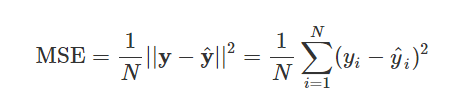

# Compute MSE and compare models

In [ ]:
mse_list = []
order_list = list(range(max_order + 1))

for order in order_list:

  X_design = make_design_matrix(x, order)

  # Get prediction for the polynomial regression model of this order
  y_hat = X_design @ theta_hats[order]

  # Compute the residuals
  residuals = y - y_hat

  # Compute the MSE
  mse = np.mean(residuals ** 2)

  mse_list.append(mse)


# Visualize MSE of fits
with plt.xkcd():
  evaluate_fits(order_list, mse_list)

# MODEL SELECTION - BIAS VARIANCE TRADE-OFF

In [ ]:
def plot_MSE_poly_fits(mse_train, mse_test, max_order):
  """
    Plot the MSE values for various orders of polynomial fits on the same bar
    graph

    Args:
      mse_train (ndarray): an array of MSE values for each order of polynomial fit
      over the training data
      mse_test (ndarray): an array of MSE values for each order of polynomial fit
      over the test data
      max_order (scalar): max order of polynomial fit
  """
  fig, ax = plt.subplots()
  width = .35

  ax.bar(np.arange(max_order + 1) - width / 2, mse_train, width, label="train MSE")
  ax.bar(np.arange(max_order + 1) + width / 2, mse_test , width, label="test MSE")

  ax.legend()
  ax.set(xlabel='Polynomial order', ylabel='MSE', title ='Comparing polynomial fits');

def ordinary_least_squares(x, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """

  return np.linalg.inv(x.T @ x) @ x.T @ y


def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression

  Args:
    x (ndarray): input vector of shape (n_samples)
    order (scalar): polynomial regression order

  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """

  # Broadcast to shape (n x 1) so dimensions work
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0],1))

  # Loop through rest of degrees and stack columns
  for degree in range(1, order+1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix


def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.

  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits

  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys, and np array of theta
  # (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order+1):

    X = make_design_matrix(x, order)
    this_theta = ordinary_least_squares(X, y)

    theta_hats[order] = this_theta

  return theta_hats

# Train vs test data

The data used for the fitting procedure for a given model is the training data. In tutorial 4, we computed MSE on the training data of our polynomial regression models and compared training MSE across models. An additional important type of data is test data. This is held-out data that is not used (in any way) during the fitting procedure. When fitting models, we often want to consider both the train error (the quality of prediction on the training data) and the test error (the quality of prediction on the test data) as we will see in the next section.

We will generate some noisy data for use in this tutorial using a similar process as in Tutorial 4. However, now we will also generate test data. We want to see how our model generalizes beyond the range of values seen in the training phase. To accomplish this, we will generate x from a wider range of values ([-3, 3]). We then plot the train and test data together.

In [ ]:
### Generate training data
np.random.seed(0)
n_train_samples = 50
x_train = np.random.uniform(-2, 2.5, n_train_samples) # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_train_samples) # sample from a standard normal distribution
y_train =  x_train**2 - x_train - 2 + noise

### Generate testing data
n_test_samples = 20
x_test = np.random.uniform(-3, 3, n_test_samples) # sample from a uniform distribution over [-2, 2.5)
noise = np.random.randn(n_test_samples) # sample from a standard normal distribution
y_test =  x_test**2 - x_test - 2 + noise

## Plot both train and test data
fig, ax = plt.subplots()
plt.title('Training & Test Data')
plt.plot(x_train, y_train, '.', markersize=15, label='Training')
plt.plot(x_test, y_test, 'g+', markersize=15, label='Test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y');


# Bias-variance tradeoff

In [ ]:
max_order = 5
theta_hats = solve_poly_reg(x_train, y_train, max_order)

# Compute and compare train vs test error
We will use MSE as our error metric again. Compute MSE on training data (xtrain,ytrain) and test data (xtest,ytest) for each polynomial regression model (orders 0-5). Since you already developed code in T4 Exercise 4 for making design matrices and evaluating fit polynomials, we have ported that here into the functions make_design_matrix and evaluate_poly_reg for your use.

Please think about it after completing the exercise before reading the following text! Do you think the order 0 model has high or low bias? High or low variance? How about the order 5 model?

In [ ]:
def evaluate_poly_reg(x, y, theta_hats, max_order):
    """ Evaluates MSE of polynomial regression models on data

    Args:
      x (ndarray): input vector of shape (n_samples)
      y (ndarray): vector of measurements of shape (n_samples)
      theta_hats (dict):  fitted weights for each polynomial model (dict key is order)
      max_order (scalar): max order of polynomial fit

    Returns
      (ndarray): mean squared error for each order, shape (max_order)
    """

    mse = np.zeros((max_order + 1))
    for order in range(0, max_order + 1):
      X_design = make_design_matrix(x, order)
      y_hat = np.dot(X_design, theta_hats[order])
      residuals = y - y_hat
      mse[order] = np.mean(residuals ** 2)

    return mse

def compute_mse(x_train, x_test, y_train, y_test, theta_hats, max_order):
  """Compute MSE on training data and test data.
  Args:
    x_train(ndarray): training data input vector of shape (n_samples)
    x_test(ndarray): test vector of shape (n_samples)
    y_train(ndarray): training vector of measurements of shape (n_samples)
    y_test(ndarray): test vector of measurements of shape (n_samples)
    theta_hats(dict): fitted weights for each polynomial model (dict key is order)
    max_order (scalar): max order of polynomial fit
  Returns:
    ndarray, ndarray: MSE error on training data and test data for each order
  """

  mse_train = evaluate_poly_reg(x_train, y_train, theta_hats, max_order)
  mse_test = evaluate_poly_reg(x_test, y_test, theta_hats, max_order)

  return mse_train, mse_test


# Compute train and test MSE
mse_train, mse_test = compute_mse(x_train, x_test, y_train, y_test, theta_hats, max_order)

# Visualize
with plt.xkcd():
  plot_MSE_poly_fits(mse_train, mse_test, max_order)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [ ]:

def plot_cross_validate_MSE(mse_all):
  """ Plot the MSE values for the K_fold cross validation

  Args:
    mse_all (ndarray): an array of size (number of splits, max_order + 1)
  """
  plt.figure()
  plt.boxplot(mse_all, labels=np.arange(0, max_order + 1))

  plt.xlabel('Polynomial Order')
  plt.ylabel('Validation MSE')
  plt.title(f'Validation MSE over {n_splits} splits of the data')
  plt.show()


def plot_AIC(order_list, AIC_list):
  """ Plot the AIC value for fitted polynomials of various orders

  Args:
    order_list (list): list of fitted polynomial orders
    AIC_list (list): list of AIC values corresponding to each polynomial model on order_list
  """
  plt.bar(order_list, AIC_list)
  plt.ylabel('AIC')
  plt.xlabel('polynomial order')
  plt.title('comparing polynomial fits')
  plt.show()

In [ ]:
def ordinary_least_squares(x, y):
  """Ordinary least squares estimator for linear regression.

  Args:
    x (ndarray): design matrix of shape (n_samples, n_regressors)
    y (ndarray): vector of measurements of shape (n_samples)

  Returns:
    ndarray: estimated parameter values of shape (n_regressors)
  """

  return np.linalg.inv(x.T @ x) @ x.T @ y


def make_design_matrix(x, order):
  """Create the design matrix of inputs for use in polynomial regression

  Args:
    x (ndarray): input vector of shape (n_samples)
    order (scalar): polynomial regression order

  Returns:
    ndarray: design matrix for polynomial regression of shape (samples, order+1)
  """

  # Broadcast to shape (n x 1)
  if x.ndim == 1:
    x = x[:, None]

  #if x has more than one feature, we don't want multiple columns of ones so we assign
  # x^0 here
  design_matrix = np.ones((x.shape[0], 1))

  # Loop through rest of degrees and stack columns
  for degree in range(1, order + 1):
      design_matrix = np.hstack((design_matrix, x**degree))

  return design_matrix


def solve_poly_reg(x, y, max_order):
  """Fit a polynomial regression model for each order 0 through max_order.

  Args:
    x (ndarray): input vector of shape (n_samples)
    y (ndarray): vector of measurements of shape (n_samples)
    max_order (scalar): max order for polynomial fits

  Returns:
    dict: fitted weights for each polynomial model (dict key is order)
  """

  # Create a dictionary with polynomial order as keys, and np array of theta
  # (weights) as the values
  theta_hats = {}

  # Loop over polynomial orders from 0 through max_order
  for order in range(max_order + 1):

    X = make_design_matrix(x, order)
    this_theta = ordinary_least_squares(X, y)

    theta_hats[order] = this_theta

  return theta_hats


def evaluate_poly_reg(x, y, theta_hats, max_order):
    """ Evaluates MSE of polynomial regression models on data

    Args:
      x (ndarray): input vector of shape (n_samples)
      y (ndarray): vector of measurements of shape (n_samples)
      theta_hat (dict): fitted weights for each polynomial model (dict key is order)
      max_order (scalar): max order of polynomial fit

    Returns
      (ndarray): mean squared error for each order, shape (max_order)
    """

    mse = np.zeros((max_order + 1))
    for order in range(0, max_order + 1):
      X_design = make_design_matrix(x, order)
      y_hat = np.dot(X_design, theta_hats[order])
      residuals = y - y_hat
      mse[order] = np.mean(residuals ** 2)

    return mse

In [ ]:
help(solve_poly_reg)

In [ ]:
help(evaluate_poly_reg)

In [ ]:
def cross_validate(x_train, y_train, max_order, n_splits):
  """ Compute MSE for k-fold validation for each order polynomial

  Args:
    x_train (ndarray): training data input vector of shape (n_samples)
    y_train (ndarray): training vector of measurements of shape (n_samples)
    max_order (scalar): max order of polynomial fit
    n_split (scalar): number of folds for k-fold validation

  Return:
    ndarray: MSE over splits for each model order, shape (n_splits, max_order + 1)

  """
  # Initialize the split method
  kfold_iterator = KFold(n_splits)

  # Initialize np array mse values for all models for each split
  mse_all = np.zeros((n_splits, max_order + 1))

  for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(x_train)):

      # Split up the overall training data into cross-validation training and validation sets
      x_cv_train = x_train[train_indices]
      y_cv_train = y_train[train_indices]
      x_cv_val = x_train[val_indices]
      y_cv_val = y_train[val_indices]

      # Fit models
      theta_hats = solve_poly_reg(x_cv_train, y_cv_train, max_order)

      # Compute MSE
      mse_this_split = evaluate_poly_reg(x_cv_val, y_cv_val, theta_hats, max_order)

      mse_all[i_split] = mse_this_split

  return mse_all


# Cross-validate
max_order = 5
n_splits = 10
mse_all = cross_validate(x_train, y_train, max_order, n_splits)

# Visualize
with plt.xkcd():
  plot_cross_validate_MSE(mse_all)


# LINEAR LIF

In [ ]:
import io
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

spike_times = pd.read_csv('DataSetCoursework_DHA.txt')
#print(spike_times)

In [ ]:
# @title Plotting Functions

def histogram(counts, bins, vlines=(), ax=None, ax_args=None, **kwargs):
  """Plot a step histogram given counts over bins."""
  if ax is None:
    _, ax = plt.subplots()

  # duplicate the first element of `counts` to match bin edges
  counts = np.insert(counts, 0, counts[0])

  ax.fill_between(bins, counts, step="pre", alpha=0.4, **kwargs)  # area shading
  ax.plot(bins, counts, drawstyle="steps", **kwargs)  # lines

  for x in vlines:
    ax.axvline(x, color='r', linestyle='dotted')  # vertical line

  if ax_args is None:
    ax_args = {}

  # heuristically set max y to leave a bit of room
  ymin, ymax = ax_args.get('ylim', [None, None])
  if ymax is None:
    ymax = np.max(counts)
    if ax_args.get('yscale', 'linear') == 'log':
      ymax *= 1.5
    else:
      ymax *= 1.1
      if ymin is None:
        ymin = 0

  if ymax == ymin:
    ymax = None

  ax_args['ylim'] = [ymin, ymax]

  ax.set(**ax_args)
  ax.autoscale(enable=False, axis='x', tight=True)

def plot_neuron_stats(v, spike_times):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

  # membrane voltage trace
  ax1.plot(v[0:100])
  ax1.set(xlabel='Time', ylabel='Voltage')
  # plot spike events
  for x in spike_times:
    if x >= 100:
      break
    ax1.axvline(x, color='red')

  # ISI distribution
  if len(spike_times)>1:
    isi = np.diff(spike_times)
    n_bins = np.arange(isi.min(), isi.max() + 2) - .5
    counts, bins = np.histogram(isi, n_bins)
    vlines = []
    if len(isi) > 0:
      vlines = [np.mean(isi)]
    xmax = max(20, int(bins[-1])+5)
    histogram(counts, bins, vlines=vlines, ax=ax2, ax_args={
      'xlabel': 'Inter-spike interval',
      'ylabel': 'Number of intervals',
      'xlim': [0, xmax]
    })
  else:
    ax2.set(xlabel='Inter-spike interval',
           ylabel='Number of intervals')
  plt.show()

In [ ]:
def lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  """ Simulate a linear integrate-and-fire neuron.
  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    rate (int): The mean rate of incoming spikes
  """
  # Precompute Poisson samples for speed
  exc = stats.poisson(rate).rvs(n_steps)

  # Initialize voltage and spike storage
  v = np.zeros(n_steps)
  #spike_times = []

  # Loop over steps
  for i in range(1, n_steps):

    # Update v
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv

    # If spike happens, reset voltage and record
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron()

# Visualize
#with plt.xkcd():
plot_neuron_stats(v, spike_times)

In [ ]:
#@title Figure Settings
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @markdown You don't need to worry about how the code works – but you do need to **run the cell** to enable the sliders.

def _lif_neuron(n_steps=1000, alpha=0.01, rate=10):
  exc = stats.poisson(rate).rvs(n_steps)
  v = np.zeros(n_steps)
  #spike_times = []
  for i in range(1, n_steps):
    dv = alpha * exc[i]
    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0
  return v, spike_times

@widgets.interact(
  alpha=widgets.FloatLogSlider(0.01, min=-2, max=-1),
  rate=widgets.IntSlider(10, min=5, max=20)
)
def plot_lif_neuron(alpha=0.01, rate=10):
  v, spike_times = _lif_neuron(2000, alpha, rate)

  plot_neuron_stats(v, spike_times)

In [ ]:
def lif_neuron_inh(n_steps=1000, alpha=0.5, beta=0.1, exc_rate=10, inh_rate=10):
  """ Simulate a simplified leaky integrate-and-fire neuron with both excitatory
  and inhibitory inputs.
  Args:
    n_steps (int): The number of time steps to simulate the neuron's activity.
    alpha (float): The input scaling factor
    beta (float): The membrane potential leakage factor
    exc_rate (int): The mean rate of the incoming excitatory spikes
    inh_rate (int): The mean rate of the incoming inhibitory spikes
  """
  # precompute Poisson samples for speed
  exc = stats.poisson(exc_rate).rvs(n_steps)
  inh = stats.poisson(inh_rate).rvs(n_steps)

  v = np.zeros(n_steps)
  
  for i in range(1, n_steps):

    dv = -beta * v[i-1] + alpha * (exc[i] - inh[i])

    v[i] = v[i-1] + dv
    if v[i] > 1:
      spike_times.append(i)
      v[i] = 0

  return v, spike_times

# Set random seed (for reproducibility)
np.random.seed(12)

# Model LIF neuron
v, spike_times = lif_neuron_inh()

# Visualize
#with plt.xkcd():
plot_neuron_stats(v, spike_times)

In [ ]:
def pmf_from_counts(counts):
  """Given counts, normalize by the total to estimate probabilities."""
  pmf = counts / np.sum(counts)

  return pmf


# Get neuron index
neuron_idx = 1

# Get counts of ISIs from Steinmetz data
isi = np.diff(spike_times[neuron_idx])
bins = np.linspace(*isi_range, n_bins + 1)
counts, _ = np.histogram(isi, bins)

# Compute pmf
pmf = pmf_from_counts(counts)

# Visualize
plot_pmf(pmf,isi_range)